In [1]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapterPlus

In [2]:
base_model_path = "/mnt/workspace/workgroup_share/lhn/models/runwayml/stable-diffusion-v1-5"
vae_model_path = "/mnt/workspace/workgroup_share/lhn/models/sd-vae-ft-mse"
image_encoder_path = "/mnt/workspace/workgroup_share/lhn/sdxl_ip_adapter_training/models/IP-Adapter/image_encoder"
ip_ckpt = "models/ip-adapter-plus-face_sd15.bin"
device = "cuda"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [4]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


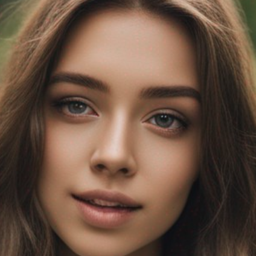

In [5]:
# read image prompt (face, here we use a ai-generation face)
image = Image.open("assets/images/ai_face.png")
image.resize((256, 256))

In [6]:
# load ip-adapter
ip_model = IPAdapterPlus(pipe, image_encoder_path, ip_ckpt, device, num_tokens=16)

  0%|          | 0/50 [00:00<?, ?it/s]

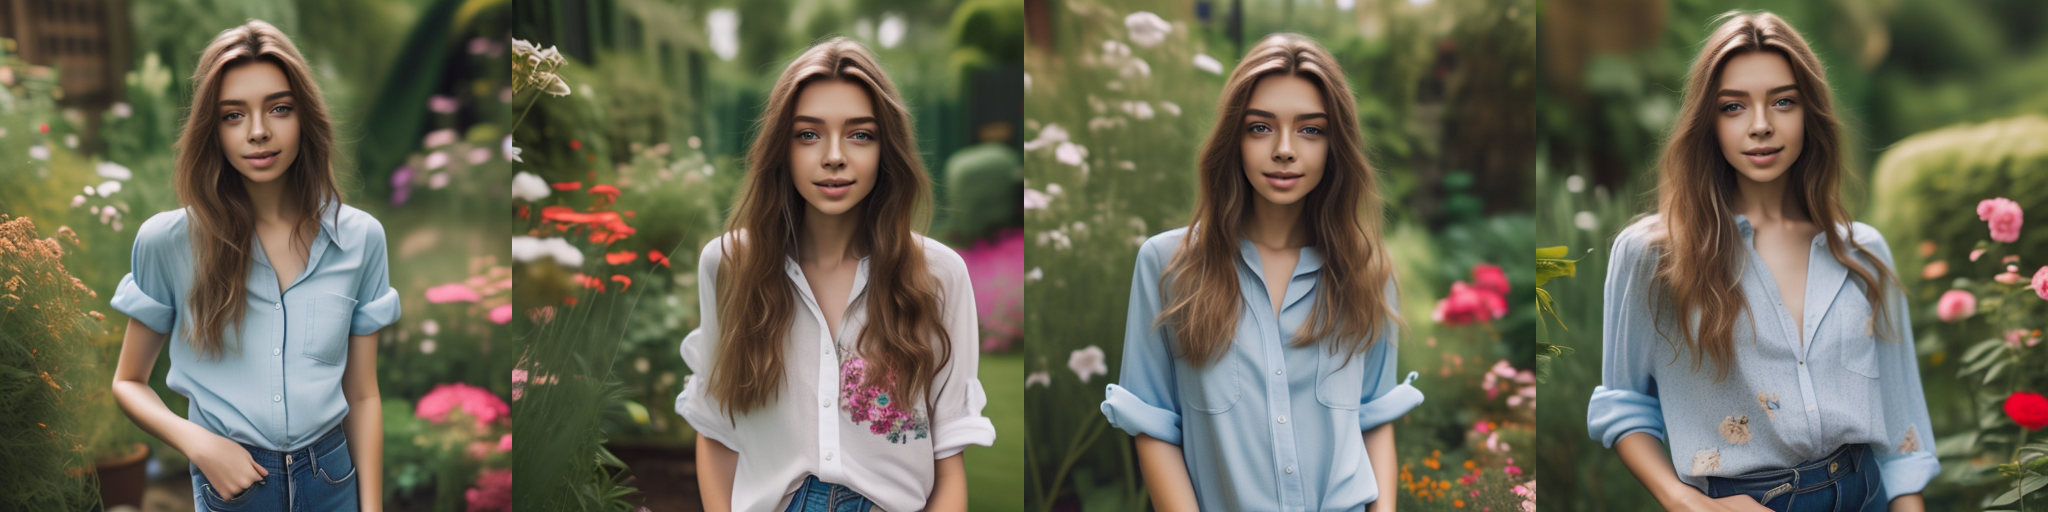

In [7]:
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=420,
        prompt="photo of a beautiful girl wearing casual shirt in a garden")
grid = image_grid(images, 1, 4)
grid

In [8]:
# Change to a anime model
del pipe, ip_model
torch.cuda.empty_cache()
base_model_path = "dreamlike-art/dreamlike-anime-1.0/"
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# load ip-adapter
ip_model = IPAdapterPlus(pipe, image_encoder_path, ip_ckpt, device, num_tokens=16)

  0%|          | 0/50 [00:00<?, ?it/s]

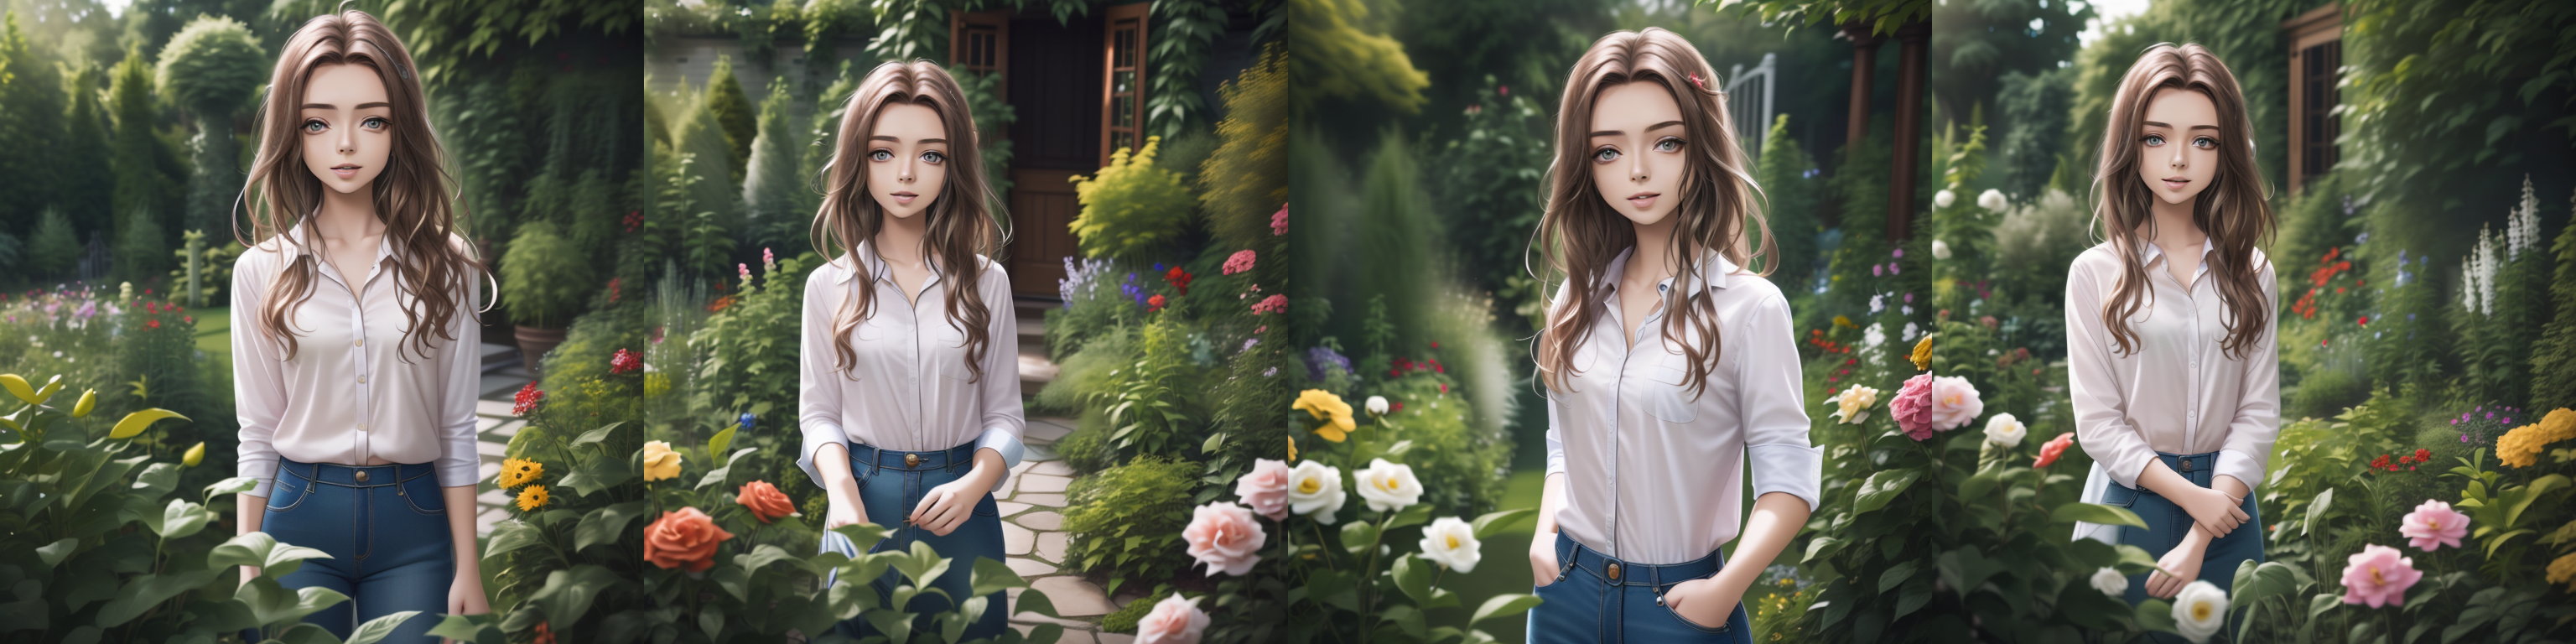

In [10]:
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=420,
        prompt="photo of a beautiful girl wearing casual shirt in a garden")
grid = image_grid(images, 1, 4)
grid